### Plot reimplantations of the same probe
- plot rasters
- plot MAD of the sites
- spike amplitude violin plots
- single unit yield

In [1]:
import labdatatools as ldt
from spks import *
from pathlib import Path
from dredge.dredge_ap import register

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams.update({'font.size': 16})

c:\Users\mmelin\anaconda3\envs\spks\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [81]:
SUBJECTS = ['MM009','MM010','MM011']
SESSIONS = ['2023-10-17/001',
            '2023-10-25/001',
            '2023-11-28/001']

DATAPATH = Path(ldt.labdata_preferences['paths'][0])
SAVEPATH = Path.home() / 'chronic_manuscript_figures'

labels = ['Reimplant 1','Reimplant 2','Reimplant 3']

In [3]:
# get the data from the Drive
#for sub, sess in zip(SUBJECTS,SESSIONS):
#    ldt.rclone_get_data(subject=sub, session=sess, datatype='spike_sorters/kilosort2.5', excludes=['**.bin']) #spike sorting
#    ldt.rclone_get_data(subject=sub, session=sess, datatype='raw_ephys_data',excludes=['*.bin','*.lf*bin']) #ephys data for MAD calculation

In [4]:
sorting_paths = [list_sorting_result_paths(DATAPATH / sub / sess) for sub, sess in zip (SUBJECTS,SESSIONS)]

In [5]:
session_clus = []
for i,session_prb_paths in enumerate(sorting_paths):
    prb_clus = []
    for j,shank_path in enumerate(session_prb_paths):
        
        shank_path = shank_path[0]
        print(shank_path)
        #clu = Clusters(shank_path, load_template_features=True)
        #clu.load_waveforms()
        #clu.compute_statistics(recompute=True)
        clu = Clusters(shank_path, load_template_features=True)
        prb_clus.append(clu)
    session_clus.append(prb_clus)

X:\labdatatools_data\MM009\2023-10-17\001\spike_sorters\kilosort2.5\imec0a
X:\labdatatools_data\MM009\2023-10-17\001\spike_sorters\kilosort2.5\imec0b
X:\labdatatools_data\MM009\2023-10-17\001\spike_sorters\kilosort2.5\imec0c
X:\labdatatools_data\MM009\2023-10-17\001\spike_sorters\kilosort2.5\imec0d
X:\labdatatools_data\MM009\2023-10-17\001\spike_sorters\kilosort2.5\imec1a
X:\labdatatools_data\MM009\2023-10-17\001\spike_sorters\kilosort2.5\imec1b
X:\labdatatools_data\MM009\2023-10-17\001\spike_sorters\kilosort2.5\imec1c
X:\labdatatools_data\MM009\2023-10-17\001\spike_sorters\kilosort2.5\imec1d
X:\labdatatools_data\MM010\2023-10-25\001\spike_sorters\kilosort2.5\imec0a
X:\labdatatools_data\MM010\2023-10-25\001\spike_sorters\kilosort2.5\imec0b
X:\labdatatools_data\MM010\2023-10-25\001\spike_sorters\kilosort2.5\imec0c
X:\labdatatools_data\MM010\2023-10-25\001\spike_sorters\kilosort2.5\imec0d
X:\labdatatools_data\MM010\2023-10-25\001\spike_sorters\kilosort2.5\imec1a
X:\labdatatools_data\MM01

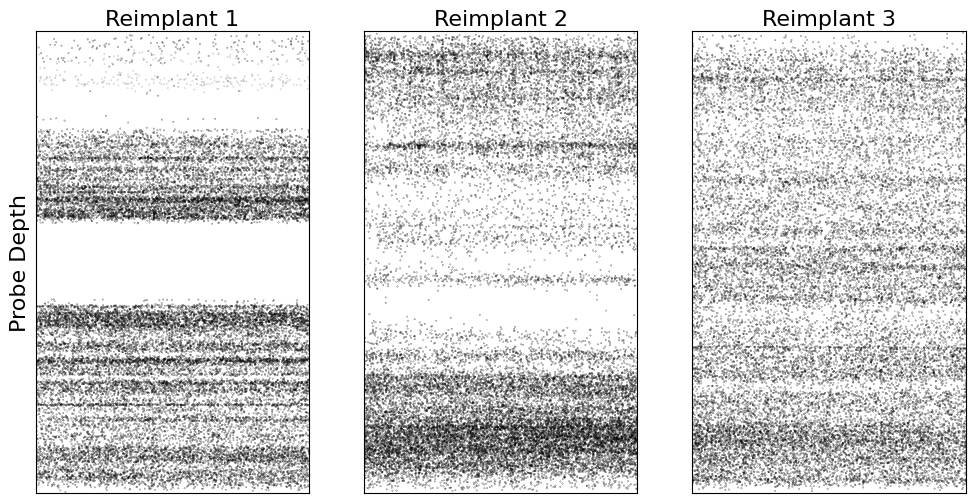

In [6]:
# Plot driftmap
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,6))

for isess, shank_clus in enumerate(session_clus):
    tidxs, idxs, sps, depths, amps = [],[],[],[],[]
    fig.add_subplot(1,len(session_clus),isess+1)
    if isess==0:
        plt.ylabel('Probe Depth')
    for ishank,clu in enumerate(shank_clus):


        sp = clu.spike_times/clu.sampling_rate
        sps.append(sp)
        depths.append(clu.spike_positions[:,1])
        amps.append(clu.spike_amplitudes)
        clusters = clu.cluster_id.flatten()
        #tidx = np.where(sp[idx]< 3000000)[0]
        #idxs.append(idx)
        #tidxs.append(tidx)
    
    sps = np.hstack(sps)
    depths = np.hstack(depths)
    amps = np.hstack(amps)
    #idxs = np.hstack(idxs)
    #tidxs = np.hstack(tidxs)

    plot_drift_raster(sps,
                    depths,
                    amps,n_spikes_to_plot=50000,clim=[0, 500],cmap='gray_r')
    plt.xlim(0,1800) #first 30 mins
    plt.yticks([])
    plt.xticks([])
    plt.gca().xaxis.set_label_position('top') 
    plt.xlabel(labels[isess])

plt.savefig(SAVEPATH / 'reimplant_rasters.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.savefig(SAVEPATH / 'reimplant_rasters.png', format='png', dpi=500, bbox_inches='tight')

In [10]:
# Get the waveform amplitudes for plotting
dat = pd.DataFrame()
n_mua, n_single = [],[]
for isess, shank_clus in enumerate(session_clus):
    all_amps, all_single_units = [],[]
    for ishank,clu in enumerate(shank_clus):
        #n_total_units= np.sum(clu.cluster_info.n_active_channels<40)
        n_total_units= len(clu)
        single_units  = ((np.abs(clu.cluster_info.trough_amplitude)>25) &
                          (clu.cluster_info.amplitude_cutoff<0.1) & 
                          (clu.cluster_info.isi_contamination<0.1))
    
        amps = np.abs(clu.trough_amplitude)
        all_amps.append(amps)
        all_single_units.append(single_units)

    all_amps = np.hstack(all_amps)
    all_single_units = np.hstack(all_single_units)
    n_single.append(np.sum(all_single_units))
    n_mua.append(np.sum(~all_single_units))

    sess = [labels[isess]] * len(all_amps)
    dat = pd.concat([dat, pd.DataFrame(zip(all_amps, all_single_units, sess))])

dat.columns = ['amps','single unit','sess']

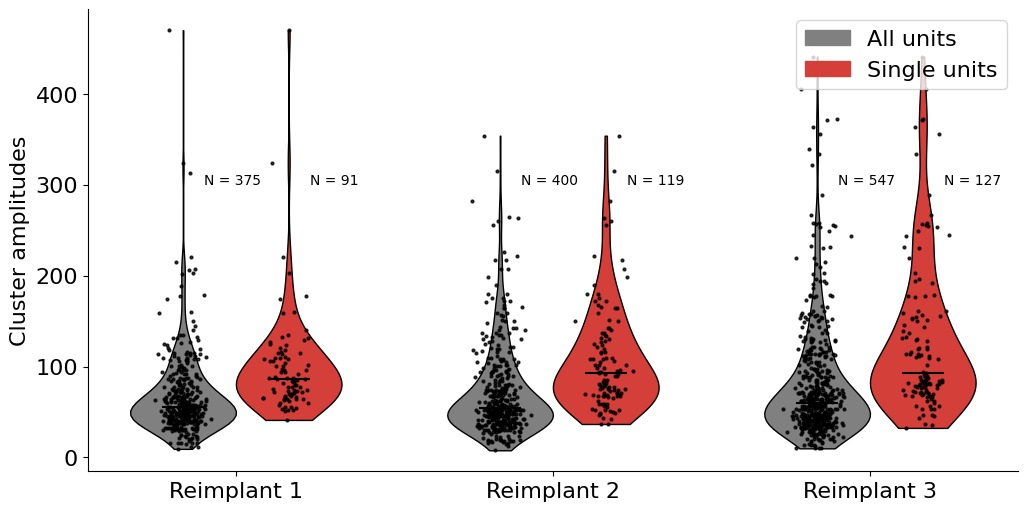

In [105]:
import matplotlib.patches as mpatches
x = 0
fdict = {'size': 10}
leg_labels, xticks = [],[]
sessions = [t for _,t in dat.groupby(dat['sess'])]


fig = plt.figure(figsize=(12,6))
for i,s in enumerate(sessions):
    all_amps = s.amps
    su_amps = s.amps[s['single unit']].values

    scatter_positions = np.random.normal(x, scale=.05, size=len(all_amps))
    parts = plt.violinplot([all_amps], [x], showmedians=False, showextrema=False) 
    plt.scatter(scatter_positions, all_amps, color='black',s=4, alpha=.8)
    plt.hlines(np.median(all_amps), x-.1, x+.1, color='black')
    plt.text(x+.1,300,f'N = {len(all_amps)}',fontdict=fdict)
    xticks.append(x+.25)
    x += .5

    for pc in parts['bodies']:
        pc.set_facecolor('grey')
        pc.set_edgecolor('black')
        pc.set_alpha(1)
    if i==0:
        color = parts['bodies'][0].get_facecolor().flatten()
        leg_labels.append((mpatches.Patch(color=color), 'All units'))

    scatter_positions = np.random.normal(x, scale=.05, size=len(su_amps))
    parts = plt.violinplot([su_amps], [x], showmedians=False, showextrema=False)
    plt.scatter(scatter_positions, su_amps, color='black',s=4, alpha=.8)
    plt.hlines(np.median(su_amps), x-.1, x+.1, color='black')
    plt.text(x+.1,300,f'N = {len(su_amps)}',fontdict=fdict)
    x += 1

    for pc in parts['bodies']:
        pc.set_facecolor('#D43F3A')
        pc.set_edgecolor('black')
        pc.set_alpha(1)
    if i==0:
        color = parts['bodies'][0].get_facecolor().flatten()
        leg_labels.append((mpatches.Patch(color=color), 'Single units'))


plt.xticks(xticks, labels)
plt.ylabel('Cluster amplitudes')
plt.xlabel('')
plt.gca().spines[['right', 'top']].set_visible(False)
plt.legend(*zip(*leg_labels), loc = 1)

plt.savefig(SAVEPATH / 'reimplant_amps.pdf', format='pdf', dpi=500)

In [112]:
# Plot MAD for each channel
from mtscomp import decompress
binfiles = [list_spikeglx_binary_paths(DATAPATH / sub / sess) for sub, sess in zip (SUBJECTS,SESSIONS)]

allmads = {}
for isess, (shank_clus,sess_files) in enumerate(zip(session_clus,binfiles)):
    sess_files = [item for sublist in sess_files for item in sublist] # flatten
    #fig.add_subplot(1,len(session_clus),isess+1)
    mads = []
    for ishank,(clu,bfile) in enumerate(zip(shank_clus,sess_files)):
        #mad = clu.metadata['channel_mad_int16'].astype(float) * clu.metadata['channel_conversion_factor'].flatten()
        if '.cbin' in bfile:
            rr = decompress(Path(bfile))
        else:
            rr = map_binary((Path(bfile)),385)
            
        #rr = RawRecording([bfile],return_voltage=True)
        gain = clu.metadata['channel_conversion_factor'][clu.channel_map].flatten() #TODO: double check this
        chunk = rr[int(30_000*100):int(30_000*130),clu.channel_map].astype(np.float32)
        tt = bandpass_filter_gpu(chunk,30000,300,10000)
        chunk = global_car_gpu(tt,return_gpu=False)
        m = mad(chunk * gain).flatten() 
        mads.append(m)
    
    mads = np.hstack(mads)
    allmads.update({labels[isess]: mads})
allmads = pd.DataFrame(allmads)

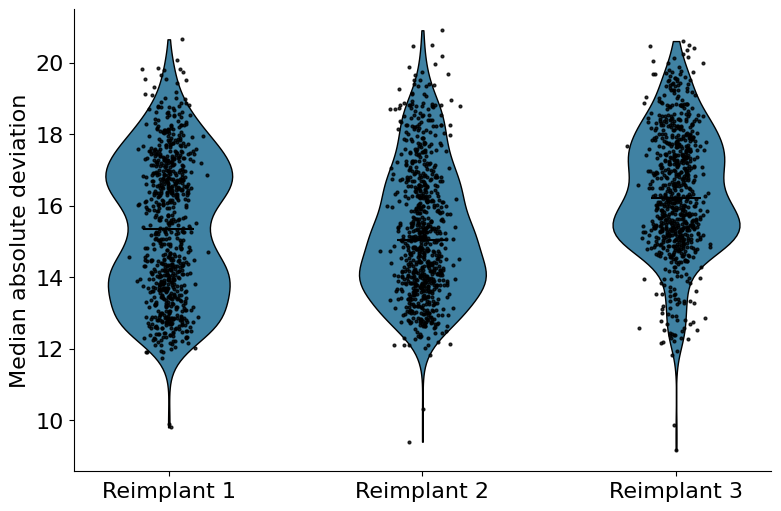

In [152]:

fig = plt.figure(figsize=(9,6))
xvals = [1,2,3]
parts = plt.violinplot(allmads.values, xvals, showmedians=False, showextrema=False)

for pc in parts['bodies']:
    pc.set_facecolor('#4082a3')
    pc.set_edgecolor('black')
    pc.set_alpha(1)

for i,x in enumerate(xvals):
    scatter_positions = np.random.normal(x, scale=.05, size=allmads.values[:,i].size)
    plt.scatter(scatter_positions, allmads.values[:,i], color='black',s=4, alpha=.8)
    plt.hlines(np.median(allmads.values[:,i]), x-.1, x+.1, color='black')

plt.xticks(xvals, labels)
plt.ylabel('Median absolute deviation')
plt.xlabel('')
plt.gca().spines[['right', 'top']].set_visible(False)

plt.savefig(SAVEPATH / 'reimplant_mad.pdf', format='pdf', dpi=500)